In [1]:
# TODO: Annotation and comments
# TODO: More Disparate Impact Analysis
# TODO: Handle Var. Imp. and save during model training

In [2]:
import os
import subprocess

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

from h2oai_client import Client

In [3]:
# global constants
SEED = 12345

DAI_USERNAME = 'phall'
DAI_PASSWORD = 'phall'

DAI_ACCURACY = 1 
DAI_TIME = 1
DAI_INTERPRETABILITY = 1

PRED_FILE_PATH = 'data' + os.sep + 'preds.csv'

In [4]:
# fetch small data
! curl https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv -o data/compas-scores-two-years.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2486k  100 2486k    0     0   708k      0  0:00:03  0:00:03 --:--:--  708k


In [5]:
data = pd.read_csv('data/compas-scores-two-years.csv')
data.drop(['name', 'first', 'last'], axis=1, inplace=True)
data.drop(['priors_count.1', 'decile_score.1'], axis=1, inplace=True) # remove some duplicate columns?
print(data.shape)

(7214, 48)


In [6]:
# clean and prepare following propublica?
clean = data[data['days_b_screening_arrest'] <= 30]
clean = clean[clean['days_b_screening_arrest'] >= -30]
clean = clean[clean['is_recid'] != -1]
clean = clean[clean['c_charge_degree'] != 'O']
clean = clean[clean['score_text'] != 'N/A']
clean['binary_target'] = np.where(clean['score_text'] == 'Low', 0, 1)
clean.shape

(6172, 49)

In [7]:
clean.head(n=10)

,id,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,start,end,event,two_year_recid,binary_target
0,1,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,327,0,0,0
1,3,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,9,159,1,1,0
2,4,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,0,63,0,1,0
5,7,2013-11-30,Male,1971-08-22,44,25 - 45,Other,0,1,0,0,0,0.0,2013-11-30 04:50:18,2013-12-01 12:28:56,13022355MM10A,2013-11-30,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,2013-11-30,Risk of Violence,1,Low,2013-11-30,2013-11-30,2013-12-01,1,853,0,0,0
6,8,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,0,6,0,0,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,14002304CF10A,2014-02-18,NaN,1.0,F,Possession Burglary Tools,1,14004485CF10A,(F2),0.0,2014-03-31,Poss of Firearm by Convic Felo,2014-03-31,2014-04-18,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Medium,2014-02-19,Risk of Violence,2,Low,2014-02-19,2014-03-31,2014-04-18,5,40,1,1,1
7,9,2013-08-30,Male,1973-02-25,43,25 - 45,Other,0,4,0,0,3,-1.0,2013-08-29 08:55:23,2013-08-30 08:42:13,13012216CF10A,NaN,2013-08-29,1.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,2013-08-30,Risk of Violence,3,Low,2013-08-30,2014-05-22,2014-06-03,0,265,0,0,0
8,10,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,0,1,0,0,0,-1.0,2014-03-15 05:35:34,2014-03-18 04:28:46,14004524MM10A,2014-03-15,NaN,1.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,2014-03-16,Risk of Violence,1,Low,2014-03-16,2014-03-15,2014-03-18,2,747,0,0,0
10,14,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,0,4,0,0,0,-1.0,2013-11-25 06:31:06,2013-11-26 08:26:57,13016402CF10A,2013-11-25,NaN,1.0,F,"Poss 3,4 MDMA (Ecstasy)",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,2013-11-26,Risk of Violence,4,Low,2013-11-26,2013-11-25,2013-11-26,0,857,0,0,0
11,15,2013-10-03,Male,1992-08-18,23,Less than 25,African-American,0,6,0,0,3,0.0,2013-10-03 04:07:35,2013-10-07 08:17:30,13018837MM10A,2013-10-03,NaN,0.0,M,Battery,1,14010414TC40A,(M2),NaN,2014-02-08,Driving License Suspended,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Medium,2013-10-03,Risk of Violence,4,Low,2013-10-03,2013-10-03,2013-10-07,4,128,1,1,1
12,16,2013-01-01,Female,1978-08-22,37,25 - 45,Caucasian,0,1,0,0,0,0.0,2013-01-01 03:28:03,2013-01-02 01:12:19,13000053MM10A,2013-01-01,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,2013-01-01,R

In [8]:
drops = list(set(clean.columns) - set(['binary_target', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree', 'priors_count', 'c_charge_desc', 'race', 'sex']))
print(drops)

['r_jail_in', 'c_days_from_compas', 'out_custody', 'r_charge_desc', 'r_days_from_arrest', 'start', 'c_jail_in', 'type_of_assessment', 'is_violent_recid', 'vr_offense_date', 'event', 'r_jail_out', 'two_year_recid', 'id', 'v_screening_date', 'vr_case_number', 'r_case_number', 'v_type_of_assessment', 'is_recid', 'v_score_text', 'end', 'c_jail_out', 'c_offense_date', 'in_custody', 'r_charge_degree', 'r_offense_date', 'violent_recid', 'v_decile_score', 'c_case_number', 'decile_score', 'screening_date', 'vr_charge_degree', 'days_b_screening_arrest', 'score_text', 'c_arrest_date', 'age_cat', 'vr_charge_desc', 'compas_screening_date', 'dob']


In [9]:
# create training data for DAI
clean.drop(drops, axis=1, inplace=True)
clean.to_csv('data/compas-scores-two-years-binary.csv')

In [10]:
if not os.path.exists(PRED_FILE_PATH):

    # connect to DAI 
    h2oai = Client(address='http://localhost:12345', username=DAI_USERNAME, password=DAI_PASSWORD)

    # save training data to disk for DAI            
    cwd = os.getcwd()
    train_path_dai = (cwd + os.sep +  'data/compas-scores-two-years-binary.csv')
    train = h2oai.create_dataset_sync(train_path_dai)

    print('Training ...')
                   
    # start experiment training               
    experiment = h2oai.start_experiment_sync(
    
        # specify data 
        dataset_key=train.key, 
        validset_key='',
        testset_key='', 
    
        # specify target & input info 
        target_col='binary_target',
        is_classification=True,
        is_timeseries=False,
        cols_to_drop=None,
        weight_col=None,
        fold_col=None,
        orig_time_col='[OFF]',
        time_col='[OFF]',
    
        # specify system hyperparameters
        enable_gpus=False,
        seed=SEED,
        accuracy=DAI_ACCURACY,
        time=DAI_TIME,
        interpretability=DAI_INTERPRETABILITY,
        scorer='auc')

    print('Final Model Score on Validation Data: ' + str(round(experiment.valid_score, 3)))   
               
    prediction = h2oai.make_prediction_sync(experiment.key, train_path_dai, output_margin=False, pred_contribs=False)
    preds_path = h2oai.download(prediction.predictions_csv_path, '.')
    preds = pd.read_csv(preds_path)
    preds.drop(['Unnamed: 0', 'binary_target.0'], axis=1, inplace=True)
    preds.rename(columns={'binary_target.1':'p_binary_target'}, inplace=True)   
    preds.to_csv(PRED_FILE_PATH)
    os.remove(preds_path)
    

               
else:   
    
    print('Loading predictions from disk ...')
    print()
    preds = pd.read_csv(PRED_FILE_PATH)
    preds.drop(['Unnamed: 0', 'binary_target.0'], axis=1, inplace=True)
    preds.rename(columns={'binary_target.1':'p_binary_target'}, inplace=True)
    print(preds.head())
    

Loading predictions from disk ...

   p_binary_target
0         0.047137
1         0.266407
2         0.854501
3         0.110160
4         0.858587


In [11]:
clean.reset_index(drop=True, inplace=True)
clean_score = pd.concat([clean, preds], axis=1)
clean_score.head(n=10)

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,binary_target,p_binary_target
0,Male,69,Other,0,0,0,0,F,Aggravated Assault w/Firearm,0,0.047137
1,Male,34,African-American,0,0,0,0,F,Felony Battery w/Prior Convict,0,0.266407
2,Male,24,African-American,0,0,1,4,F,Possession of Cocaine,0,0.854501
3,Male,44,Other,0,0,0,0,M,Battery,0,0.110160
4,Male,41,Caucasian,0,0,0,14,F,Possession Burglary Tools,1,0.858587
5,Male,43,Other,0,0,0,3,F,arrest case no charge,0,0.242646
6,Female,39,Caucasian,0,0,0,0,M,Battery,0,0.116491
7,Male,27,Caucasian,0,0,0,0,F,"Poss 3,4 MDMA (Ecstasy)",0,0.480110
8,Male,23,African-American,0,0,0,3,M,Battery,1,0.689319
9,Female,37,Caucasian,0,0,0,0,M,Battery,0,0.124840


In [12]:
def get_roc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    frame_ = frame.copy(deep=True)
    dname = 'd_' + str(y)
    eps = 1e-100
    
    roc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    for cutoff in np.arange(0, 1 + res, res):

        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]
        
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        roc_frame = roc_frame.append({'cutoff': cutoff,
                                      'recall': recall,
                                      'precision': precision,
                                      'f1': f1}, 
                                      ignore_index=True)
    
    del frame_
    
    return roc_frame
        
roc_frame = get_roc(clean_score, 'binary_target', 'p_binary_target')

In [13]:
best_cut = roc_frame.loc[roc_frame['f1'].idxmax(), 'cutoff']

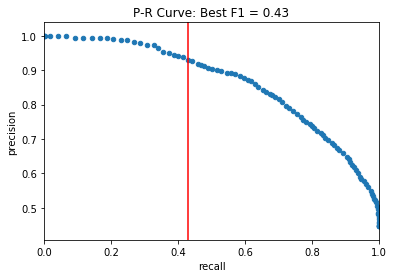

In [14]:
%matplotlib inline
title_ = 'P-R Curve: Best F1 = ' + str(best_cut)
ax = roc_frame.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(best_cut, color='r')

In [15]:
def get_confusion_matrix(frame, y, yhat, target_label='target', by=None, level=None, cutoff=0.5):

    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    frame_ = frame.copy(deep=True)
    
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[i, j] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
    
    if by is None:
        print('Confusion matrix:')
    else:
        print('Confusion matrix by ' + by + '=' + level)
    
    return cm_frame
    
    
get_confusion_matrix(clean_score, 'binary_target', 'p_binary_target')

Confusion matrix:


,actual: 1,actual: 0
predicted: 1,1984,767
predicted: 0,509,2912


In [16]:
# Disparate Impact Analysis

In [17]:
races = list(clean_score['race'].unique())
races

['Other',
 'African-American',
 'Caucasian',
 'Hispanic',
 'Asian',
 'Native American']

In [18]:
other_cm = get_confusion_matrix(clean_score, 'binary_target', 'p_binary_target', by='race', level='Other')
other_cm

Confusion matrix by race=Other


,actual: 1,actual: 0
predicted: 1,46,24
predicted: 0,38,235


In [19]:
afam_cm = get_confusion_matrix(clean_score, 'binary_target', 'p_binary_target', by='race', level='African-American')
afam_cm

Confusion matrix by race=African-American


,actual: 1,actual: 0
predicted: 1,1400,429
predicted: 0,255,1091


In [20]:
cauc_cm = get_confusion_matrix(clean_score, 'binary_target', 'p_binary_target', by='race', level='Caucasian')
cauc_cm

Confusion matrix by race=Caucasian


,actual: 1,actual: 0
predicted: 1,427,269
predicted: 0,172,1235


In [21]:
hisp_cm = get_confusion_matrix(clean_score, 'binary_target', 'p_binary_target', by='race', level='Hispanic')
hisp_cm

Confusion matrix by race=Hispanic


,actual: 1,actual: 0
predicted: 1,99,42
predicted: 0,42,326


In [22]:
asian_cm = get_confusion_matrix(clean_score, 'binary_target', 'p_binary_target', by='race', level='Asian')
asian_cm

Confusion matrix by race=Asian


,actual: 1,actual: 0
predicted: 1,4,3
predicted: 0,2,22


In [23]:
Natam_cm = get_confusion_matrix(clean_score, 'binary_target', 'p_binary_target', by='race', level='Native American')
Natam_cm

Confusion matrix by race=Native American


,actual: 1,actual: 0
predicted: 1,8,0
predicted: 0,0,3
